In [68]:
#Load the usual suspects

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [69]:
# Load the data

with np.load('/Users/David/Desktop/EPFL Applied ML/cifar4-train.npz', allow_pickle=False) as npz_file:
    pixels = npz_file['pixels'].astype('float32')
    overfeat = npz_file['overfeat']
    labels = npz_file['labels']
    names = npz_file['names']
    allow = npz_file['allow_pickle']
    
print('Pixels : {:}'.format(pixels.shape),
      'Overfeat: {:}'.format(overfeat.shape),
      'Labels: {:}'.format(labels.shape),
      'Names: {:}'.format(names.shape), 
      'Allow pickle: {:}'.format(allow.shape))

Pixels : (5000, 3072) Overfeat: (5000, 4096) Labels: (5000,) Names: (4,) Allow pickle: ()


In [70]:
# Rename the data and split into train (3200), test (1000) and validation (800) sets
X_ov = overfeat
X_px = pixels
y = labels

X_ov_tr, X_ov_te, X_px_tr, X_px_te, y_tr, y_te = train_test_split(X_ov, X_px, y, test_size=1000, stratify=y, random_state=0)
X_ov_tr, X_ov_val, X_px_tr, X_px_val, y_tr, y_val = train_test_split(X_ov_tr, X_px_tr, y_tr, test_size=800, stratify=y_tr, random_state=0)

# Double check dimensions for the overfeat data:
print('Train set: {:}'.format(X_ov_tr.shape), 'Test set: {:}'.format(X_ov_te.shape), 'Validation set: {:}'.format(X_ov_val.shape))

Train set: (3200, 4096) Test set: (1000, 4096) Validation set: (800, 4096)


In [71]:
# Create a decision tree using a pipeline:

dt_pipe = Pipeline([
    ('scaler', StandardScaler()), # scaling step. A decision tree does not depend on distance so this step could be skipped
    ('pca', PCA(n_components=176)), # pca step with 176 to get 90% of the proportion of variance explained. It also reduces dimensionality, which increases algorithm speed and accuracy
    ('dt', DecisionTreeClassifier()) # leave default settings
])

# Create a list with the iterable values to feed the decision tree model
depth = [None, 1, 2, 5, 10, 15, 20, 50, 100, 250] # list of potential tree depths 

# Create grid search object
dt_grid = ParameterGrid({
    'dt__max_depth' : depth
})

# Save accuracy on training and validation sets, starting with an empty list
dt_scores = []

for i in dt_grid:
    # Set parameters
    dt_pipe.set_params(**i)

    # Fit the decision tree classifier
    dt_pipe.fit(X_ov_tr, y_tr)

    # Save accuracy on training set and add them to the training results
    i['train accuracy'] = dt_pipe.score(X_ov_tr, y_tr)
    i['validation accuracy'] = dt_pipe.score(X_ov_val, y_val)
    dt_scores.append(i)

In [72]:
# Put everything nicely into a dataframe and print the best validation accuracies
dt_df = pd.DataFrame(dt_scores) # create a dataframe from a dictionary
dt_df.columns = ['tree depth', 'train accuracy', 'validation accuracy'] # column names
dt_df.replace({'tree depth': {np.nan: None}}, inplace=True) # tree depth mapping

print('Top accuracy on validation set: {:.5f}'.format(dt_df['validation accuracy'].max()), 
      'for depth: {:.0f}'.format(dt_df['tree depth'][dt_df['validation accuracy'].idxmax()]))

Top accuracy on validation set: 0.67250 for depth: 5


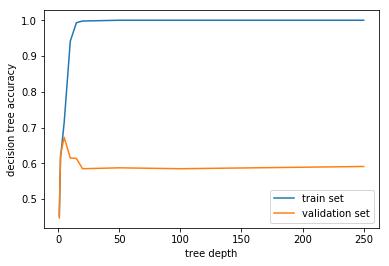

In [73]:
# Plot the training and validation curves

plt.plot(dt_df['tree depth'], dt_df['train accuracy'], label='train set')
plt.plot(dt_df['tree depth'], dt_df['validation accuracy'], label='validation set')

plt.legend()
plt.xlabel('tree depth')
plt.ylabel('decision tree accuracy')

plt.show() #the train accuracy reaches 1.0 pretty quickly, which means that it is overfitting quite rapidly with increasing tree depth. This is translated to the validation set, with the model losing generality when the training set overfits the data.

In [74]:
# Create a random forest using a pipeline:

rf_pipe = Pipeline([
    ('scaler', StandardScaler()), # scaling step. A decision tree does not depend on distance so this step could be skipped
    ('pca', PCA(n_components=176)), # pca step with 176 to get 90% of the proportion of variance explained. It also reduces dimensionality, which increases algorithm speed and accuracy
    ('rf', RandomForestClassifier()) # leave default settings
])

# Create a list with the iterable values to feed the random model
forest = [5, 10, 50, 100, 200]
depth = [None, 1, 2, 5, 10, 15, 20, 50, 100] # list of potential tree depths 

# Create grid search object
rf_grid = ParameterGrid({
    'rf__max_depth' : depth,
    'rf__n_estimators' : forest
})

# Save accuracy on training and validation sets, starting with an empty list
rf_scores = []

for i in rf_grid:
    # Set parameters
    rf_pipe.set_params(**i)

    # Fit the random forest classifier
    rf_pipe.fit(X_ov_tr, y_tr)

    # Save accuracy on training set and add them to the training results
    i['validation accuracy'] = rf_pipe.score(X_ov_val, y_val)
    rf_scores.append(i)

In [75]:
# Put everything nicely into a dataframe and print the best validation accuracy
rf_df = pd.DataFrame(rf_scores) # create a dataframe from a dictionary
rf_df.columns = ['tree depth', 'number of trees', 'validation accuracy'] # column names
rf_df.replace({'tree depth': {np.nan: None}}, inplace=True) # tree depth mapping

print('Top accuracy on validation set: {:.5f}'.format(rf_df['validation accuracy'].max()), 
      'for number of trees: {:.0f}'.format(rf_df['number of trees'][rf_df['validation accuracy'].idxmax()]))

rf_df.sort_values(by='validation accuracy', ascending=False).head(10) # dataframe showing the 10 cases with the best validation accuracies

Top accuracy on validation set: 0.78500 for number of trees: 200


,tree depth,number of trees,validation accuracy
24,10,200,0.78500
39,50,200,0.77125
34,20,200,0.77000
3,None,100,0.77000
4,None,200,0.77000
38,50,100,0.76500
28,15,100,0.76375
29,15,200,0.76125
44,100,200,0.75875
37,50,50,0.75750


In [76]:
# Finally, fit your (tuned) decision tree and random forest estimators on the entire train set with 4,000 data points and evaluate them on the test set. Print the accuracy values.

# For the decision tree classifier
dt_pipe.set_params(dt__max_depth=dt_df['tree depth'][dt_df['validation accuracy'].idxmax()]).fit(X_ov_tr, y_tr)

print('Decision tree accuracy (test set): {:.5f}'.format(dt_pipe.score(X_ov_te, y_te)))

# For the random forest classifier
rf_pipe.set_params(rf__max_depth=rf_df['tree depth'][rf_df['validation accuracy'].idxmax()],
                  rf__n_estimators=rf_df['number of trees'][rf_df['validation accuracy'].idxmax()]).fit(X_ov_tr, y_tr)

print('Random forest accuracy (test set): {:.5f}'.format(rf_pipe.score(X_ov_te, y_te)))

#as expected, the random forest is able to generalize better to the data while avoiding the problems with overfitting that decision trees tend to have

Decision tree accuracy (test set): 0.66500
Random forest accuracy (test set): 0.77800
